<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [24]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms

In [25]:
print(tf.__version__)

use_int8 = False  # use int8 input tensor
print("use_int8: ", use_int8)

2.14.0
use_int8:  False


In [26]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 96
img_height = 96
img_channels = 3
mode = "resize"  # "crop" or "resize
model_name = "model_TL"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [27]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'labtrack-leftonly-RTCSA22.zip' # 'Dataset-kucsl-Aug2022-zero.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

# if not os.path.isfile(dataset_zipfile):
#     default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
#     print ("No existing dataset. download from ", default_dataset_URL)
#     r = requests.get(default_dataset_URL)
#     open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [28]:
# Train/test data lists
imgs = []
vals = []

def rad2deg(rad):
    return 180.0 * rad / math.pi
def deg2rad(deg):
    return math.pi * deg / 180.0

# Scale the image to the model input size
def get_image_resize(img):
    orig_h, orig_w, orig_c = img.shape
    scaled_img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_NEAREST) 
                    # INTER_NEAREST (one implemented in the esp32-s3), 
                    # INTER_LINEAR, INTER_AREA (default), INTER_CUBIC, INTER_LANCZOS4

    # scale_x = int(orig_w / img_width)
    # scale_y = int(orig_h / img_height)

    # for i in range(img_height):
    #     for j in range(img_width):
    #         for k in range(orig_c):
    #             if scaled_img[i,j,k] != img[i*scale_y,j*scale_x,k]:
    #                 print("error", i, j, k, scaled_img[i,j,k], img[i*scale_y,j*scale_x,k])
    return scaled_img

# Crop the image to the model input size
def get_image_crop(img):
    orig_h, orig_w, _ = img.shape
    startx = int((orig_w - img_width) * 0.5); # crop from both sides
    starty = int((orig_h - img_height) * 0.75); # crop from bottom
    return img[starty:starty+img_height, startx:startx+img_width,:]

def preprocess(img):
    if mode == "crop":
        img = get_image_crop(img)
    elif mode == "resize":  
        img = get_image_resize(img)
    # Convert to grayscale and readd channel dimension
    if img_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.reshape(img, (img_height, img_width, img_channels))
    if use_int8 == True:
        img = (img - 128).astype(np.int8)
    else:
        img = img.astype(np.float32) / 255.0
    return img

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)

    for val in df["wheel"].values:
        ret,img = vid.read()
        img = preprocess(img)
        imgs.append(img)
        vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-t50-ittc-right-01.avi dataset/out-key-t50-ittc-right-01.csv
1000 1000
dataset/out-video-t50-ittc-right-00.avi dataset/out-key-t50-ittc-right-00.csv
2000 2000
dataset/out-video-t50-ittc-right-02.avi dataset/out-key-t50-ittc-right-02.csv
3000 3000
dataset/out-video-t50-ittc-right-03.avi dataset/out-key-t50-ittc-right-03.csv
4000 4000
dataset/out-video-t50-ittc-right-04.avi dataset/out-key-t50-ittc-right-04.csv
5000 5000
dataset/out-video-t50-ittc-left-03.avi dataset/out-key-t50-ittc-left-03.csv
6000 6000
dataset/out-video-t50-ittc-left-02.avi dataset/out-key-t50-ittc-left-02.csv
7000 7000
dataset/out-video-t50-ittc-left-00.avi dataset/out-key-t50-ittc-left-00.csv
8000 8000
dataset/out-video-t50-ittc-left-01.avi dataset/out-key-t50-ittc-left-01.csv
9000 9000
dataset/out-video-t50-ittc-left-04.avi dataset/out-key-t50-ittc-left-04.csv
10000 10000
Loaded 10000 smaples


In [29]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print("class_weights", class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
print("class_weights", class_weights)


Train/Test
class_weights [2.08333333 0.49144879 2.06100577]
class_weights {0: 2.0833333333333335, 1: 0.49144879103597405, 2: 2.061005770816158}


In [30]:
len(x_train)

7500

In [31]:
from keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# feature_extractor = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(96, 96, 3))

MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/5"
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                  input_shape=(img_height,img_width,img_channels),
                                  trainable=True)
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, name="output",activation='tanh')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 492257 (1.88 MB)
Trainable params: 478177 (1.82 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [32]:

print ("Model compile")
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
		                loss=tf.keras.losses.MeanSquaredError())
model.summary()

Model compile
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 492257 (1.88 MB)
Trainable params: 478177 (1.82 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


Model fit
Epoch 1/25
59/59 [==============================] - 34s 499ms/step - loss: 0.1672 - val_loss: 0.2287
Epoch 2/25
59/59 [==============================] - 33s 557ms/step - loss: 0.0691 - val_loss: 0.1460
Epoch 3/25
59/59 [==============================] - 31s 528ms/step - loss: 0.0524 - val_loss: 0.1310
Epoch 4/25
59/59 [==============================] - 33s 550ms/step - loss: 0.0438 - val_loss: 0.1110
Epoch 5/25
59/59 [==============================] - 35s 586ms/step - loss: 0.0400 - val_loss: 0.1040
Epoch 6/25
59/59 [==============================] - 35s 594ms/step - loss: 0.0382 - val_loss: 0.0928
Epoch 7/25
59/59 [==============================] - 37s 630ms/step - loss: 0.0367 - val_loss: 0.0887
Epoch 8/25
59/59 [==============================] - 35s 591ms/step - loss: 0.0356 - val_loss: 0.0835
Epoch 9/25
59/59 [==============================] - 34s 566ms/step - loss: 0.0351 - val_loss: 0.0811
Epoch 10/25
59/59 [==============================] - 35s 582ms/step - loss: 0.034

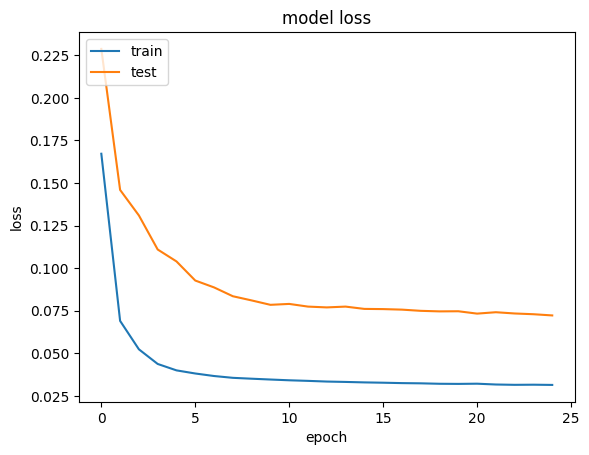

In [33]:
print ("Model fit")
# q_aware_model.reset_states()
history = model.fit(x_train, y_train, batch_size=128,
                    epochs=25, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
angle_thresh=10
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < angle_thresh and degree > -angle_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"

pred_angle = model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

79/79 [==============================] - 4s 24ms/step
Accuracy is 0.802


visualization

In [34]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

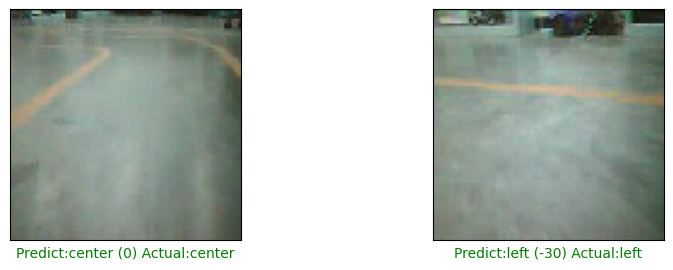

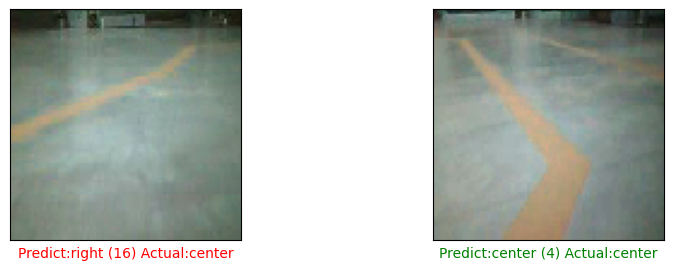

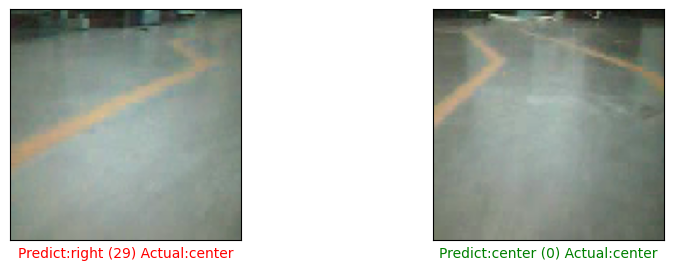

In [37]:
#@title Visualize the outputs { run: "auto" }
index = 100 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

In [38]:

print (model_file)

models/TL-96x96x3-TL


In [13]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")


print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
print("Using representative dataset")

print("Using int8 quantization")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((imgs)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]
converter.representative_dataset = representative_dataset
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

quantized_tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save


/Users/h488y928/tensorflow-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite Model
Using representative dataset
Using int8 quantization
INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6ghbfx3a/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6ghbfx3a/assets
/Users/h488y928/tensorflow-metal/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-10-03 19:42:44.444467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-03 19:42:44.444634: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-03 19:42:44.449670: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6ghbfx3a
2023-10-03 19:42:44.461705: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-03 19:42:44.461718: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>
models/opt-96x96x3.tflite is saved. copy this file to the robot


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [14]:
!pwd

/Users/h488y928/Projects/DeepPicar-ESP32S3


generate cc file from tflite model

In [15]:
!xxd -i {model_file}.tflite > {model_file}.cc
print ("src/"+model_file[7:]+".cc is saved")
!cat {model_file}.cc | sed "s/unsigned/const unsigned/g" > src/{model_file[7:]}.cc

src/opt-96x96x3.cc is saved
